# Motion detection

In [82]:
import cv2 
from matplotlib import pyplot as plt
from IPython.display import clear_output, Image, display, Video, HTML
import mediapy as media
import numpy as np
from moviepy.editor import *
from dataloader import * 

  from .autonotebook import tqdm as notebook_tqdm



In [39]:
# # OLD 

# test = '/home/ahreumseo/research/violence/datasets/RWF2000-Video-Database-for-Violence-Detection/Dataset/dataset/train/NonFight/-1l5631l3fg_1.avi'
# clip=VideoFileClip(test)
# clip.ipython_display(width=280)
# cap = cv2.VideoCapture(test)

# while(cap.isOpened()):
#     ret, frame = cap.read()
# #     print(frame, ret)
#     if ret:
# #         cv2.imshow("frame", frame)
# #         plt.imshow(frame)
# #         plt.title('my picture')
# #         plt.show()
#         media.show_videos(np.expand_dims(frame, [0,1]), codec='gif', fps=30)
#         cv2.waitKey(1)
#     else:
#         break
    
#     break

# cap.release()
# cv2.destroyAllWindows()

### Load data 

In [87]:
val_generator = DataGenerator_past(directory='/home/ahreumseo/research/violence/datasets/RWF2000-Video-Database-for-Violence-Detection/Dataset/dataset_npy_5fps/val',
                              batch_size=1, 
                              data_augmentation=False)

Found 400 files belonging to 2 classes.
     Fight :  0
  NonFight :  1


In [168]:
sample_video = val_generator[10][0]
sample_video.shape

(1, 25, 224, 224, 3)

""

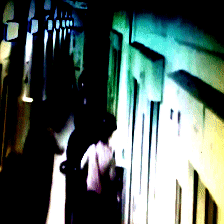

In [93]:
media.show_videos(sample_video, codec='gif', fps=30)

### Detect motion with 5 frames 

In [108]:
for i in range(sample_video.shape[1]):
    if i%5 == 0: 
        print(i, sample_video[0][i:i+5].shape
        # 5 프레임 가지고 Motion detection 수행 
        

0 (5, 224, 224, 3)
5 (5, 224, 224, 3)
10 (5, 224, 224, 3)
15 (5, 224, 224, 3)
20 (5, 224, 224, 3)


### Motion detector implementaion with intermediate test (2 frames) 

In [112]:
back = sample_video[0][0]
print(back.shape)
# 연산 속도를 높이기 위해 그레이스케일 영상으로 변환
back = cv2.cvtColor(back, cv2.COLOR_BGR2GRAY)

# 가우시안 블러로 노이즈 제거 (모폴로지, 열기, 닫기 연산도 가능)
back = cv2.GaussianBlur(back, (0, 0), 1.0)

(224, 224, 3)


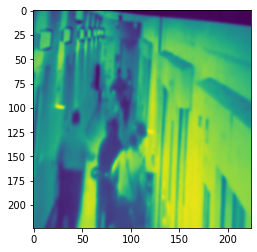

In [113]:
plt.imshow(back)

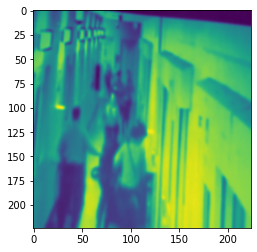

In [115]:
frame = sample_video[0][1]
# 현재 프레임 영상 그레이스케일 변환
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# 노이즈 제거
gray = cv2.GaussianBlur(gray, (0, 0), 1.0)
plt.imshow(gray)

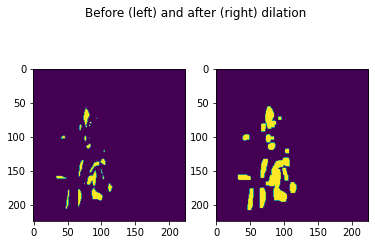

In [192]:
# 차영상 구하기 $ 이진화
# absdiff는 차 영상에 절대값
diff = cv2.absdiff(gray, back)

# Dilute the image a bit to make differences more seeable 
kernel = np.ones((5, 5))
diff2 = cv2.dilate(diff, kernel, 1)

# 차이가 threshold 이상:  255(흰색), else: 0(검정색)
_, diff = cv2.threshold(diff, 1, 255, cv2.THRESH_BINARY)
_, diff2 = cv2.threshold(diff2, 1, 255, cv2.THRESH_BINARY)


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Before (left) and after (right) dilation')
ax1.imshow(diff)
ax2.imshow(diff2)

In [193]:
# uint8로 dtype 변환
diff = diff.astype(np.uint8)
diff2 = diff2.astype(np.uint8)

In [194]:
# 레이블링을 이용하여 바운딩 박스 표시
cnt, _, stats, _ = cv2.connectedComponentsWithStats(diff)
cnt2, _, stats2, _ = cv2.connectedComponentsWithStats(diff2)

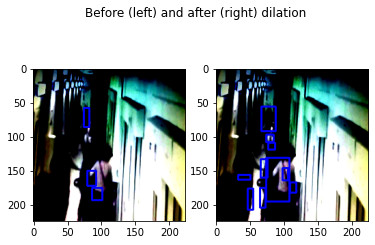

In [195]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Before (left) and after (right) dilation')

frame = sample_video[0][1].copy()
for i in range(1, cnt):
    x, y, w, h, s = stats[i]

    if s < 100:
        continue

    cv2.rectangle(frame, (x, y, w, h), (0, 0, 255), 2)
ax1.imshow(frame)

frame = sample_video[0][1].copy()
for i in range(1, cnt2):
    x, y, w, h, s = stats2[i]

    if s < 100:
        continue

    cv2.rectangle(frame, (x, y, w, h), (0, 0, 255), 2)
ax2.imshow(frame)

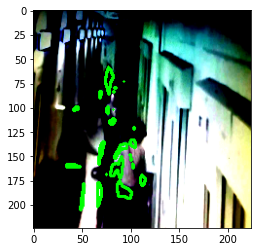

In [196]:
frame = sample_video[0][1].copy()
contours, _ = cv2.findContours(image=diff, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image=frame, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
plt.imshow(frame)

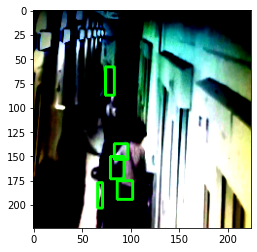

In [197]:
frame_box = sample_video[0][1].copy()
for contour in contours:
  if cv2.contourArea(contour) < 50:
    # too small: skip!
    continue
  (x, y, w, h) = cv2.boundingRect(contour)
  cv2.rectangle(img=frame_box, pt1=(x, y), pt2=(x + w, y + h), color=(0, 255, 0), thickness=2)
plt.imshow(frame_box)ㅠ

In [ ]:
# Motion detection -> bounding box 등으로 표시 -> 프레임 이어붙여서 영상 만들어 저장

### Motion detection with 3+ frames


각 프레임 간의 차이 추출 --> bitwise and 연산으로 겹치는 부분 찾기 

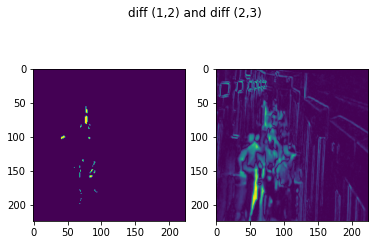

In [208]:
thresh = 1

a,b,c = sample_video[0][0], sample_video[0][2], sample_video[0][4] 

a_gray = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
b_gray = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
c_gray = cv2.cvtColor(c, cv2.COLOR_BGR2GRAY)
 

diff1 = cv2.absdiff(a_gray, b_gray)
diff2 = cv2.absdiff(b_gray, c_gray)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('diff (1,2) and diff (2,3)')
ax1.imshow(diff)
ax2.imshow(diff2)

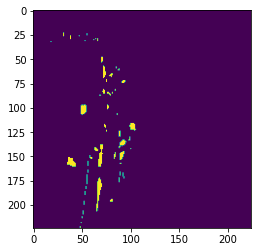

In [209]:
ret, diff1_t = cv2.threshold(diff1, thresh, 255, cv2.THRESH_BINARY)
ret, diff2_t = cv2.threshold(diff2, thresh, 255, cv2.THRESH_BINARY)

diff = cv2.bitwise_and(diff1_t, diff2_t)
plt.imshow(diff)

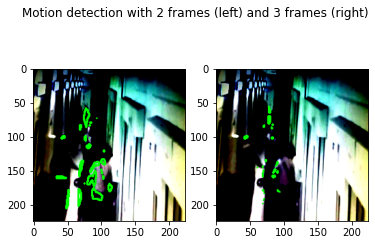

In [200]:
frame2 = sample_video[0][2].copy()
diff = diff.astype(np.uint8)
contours, _ = cv2.findContours(image=diff, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image=frame2, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Motion detection with 2 frames (left) and 3 frames (right)')
ax1.imshow(frame)
ax2.imshow(frame2)

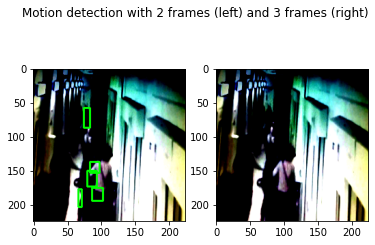

In [204]:
frame_box2 = sample_video[0][1].copy()
for contour in contours:
  if cv2.contourArea(contour) < 50:
    # too small: skip!
    continue
  (x, y, w, h) = cv2.boundingRect(contour)
  cv2.rectangle(img=frame_box2, pt1=(x, y), pt2=(x + w, y + h), color=(0, 255, 0), thickness=2)
  print('motion detected')
    
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Motion detection with 2 frames (left) and 3 frames (right)')
ax1.imshow(frame_box)
ax2.imshow(frame_box2)

### Test my motion detector

In [221]:
def preprocessing(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.GaussianBlur(frame, (0, 0), 1.0)
    return frame 

def motion_detector(clip, threshold = 1):

    a,b,c = clip[0][0], clip[0][2], clip[0][4] 
    a,b,c = preprocessing(a), preprocessing(b), preprocessing(c)
    
    diff1 = cv2.absdiff(a, b)
    diff2 = cv2.absdiff(b, c)

    ret, diff1_t = cv2.threshold(diff1, threshold, 255, cv2.THRESH_BINARY)
    ret, diff2_t = cv2.threshold(diff2, threshold, 255, cv2.THRESH_BINARY)

    diff = cv2.bitwise_and(diff1_t, diff2_t)
    diff = diff.astype(np.uint8)

    contours, _ = cv2.findContours(image=diff, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)



    for contour in contours:
        if cv2.contourArea(contour) < 50:
            # too small: skip!
            continue
        else:
            return True

    return False 

In [222]:
clip = sample_video[:, 0:5, :, :, :]
clip.shape

(1, 5, 224, 224, 3)

In [223]:
motion_detector(clip)

True

# Object detection

In [77]:
import tensorflow as tf 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import pathlib
import collections

In [18]:
frame = cv2.resize(frame, (640,640))

In [19]:
frame.shape

(640, 640, 3)

In [37]:
model_path = '/home/ahreumseo/research/violence/datasets/MoViNet-TF/EVD/official/projects/movinet/efficientdet_d1_coco17_tpu-32/saved_model'
# model_path = '/home/ahreumseo/research/violence/datasets/MoViNet-TF/EVD/official/projects/movinet/yolov5/yolov5s_saved_model'

detect_fn = tf.saved_model.load(model_path)